
# Predicting the Price of Used Cars Using Machine Learning Algorithms
<font color = 'Blue'> 
Names: Shin Le, Jeongyeon Kim, Benjamin Horvath, Nico Reategui, Paul Giglio


Proposal: https://docs.google.com/document/d/1zhQrkWmJjjMU6wIfBC78MygGzp-XUrkaUOWALfyAL9Q/edit

Dataset: https://www.kaggle.com/datasets/wspirat/germany-used-cars-dataset-2023/data

<a id="0"></a> <br>
<font color = 'Blue'> 
# Table of Contents

1. [About Dataset](#1)
1. [Importing Libraries](#2)
1. [Functions Implementation](#3)
1. [Loading Data](#4)
1. [Data Preprocessing](#5)
1. [Exploratory Data Analysis (EDA)](#6)
1. [Data Splitting](#7)
1. [Models Evaluations and Predictions](#8)
   1. [*Full Model* with *Linear Regression*](#81)
   1. [Using Sequential Feature Selection for the *Linear Regression*](#82)
   1. [*Decision Tree*](#83)
   1. [*A Pruned Tree*](#84)
   1. [Ensemble Method: *Random Forest Regression*](#85)
   1. [Ensemble Method: *Gradient Boosting Regression*](#86)
   1. [*Support Vector Machine* (SVM)](#87)


<a id="1"></a>
<font color = 'blue'> 
## **1. About Dataset**

<a id="2"></a>
<font color = 'blue'> 
## **2. Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # Corrected import
%matplotlib inline  # Ensures that Matplotlib plots are displayed inline

import statsmodels.api as sm


#preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder 




UsageError: unrecognized arguments: # Ensures that Matplotlib plots are displayed inline


<a id="3"></a>
<font color = 'blue'> 
## **3. Functions Implementation**


<a id="4"></a>
<font color = 'blue'> 
## **4. Loading Data**

<div class="alert alert-block alert-warning">
<b>Note:</b>

You have to update the link if there is an error when you load data. 

* Open **Github** -> Open the dataset - **germanycars.csv** --> Click "**View Raw**" --> **Copy the link**

You must save before you are able to **Commit & Push** 
* You can go to **File --> Auto Save**
</div>


In [2]:
'''
# Define the URL of the CSV file on GitHub
csv_url = "https://raw.githubusercontent.com/syl21b/Car-Price-Prediction/main/germanycars.csv?token=GHSAT0AAAAAACIQMGDUI2ZHP5YRJCPW4ZVKZJ37DUA"

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_url)

# Now you have the data in the 'df' DataFrame'''

'\n# Define the URL of the CSV file on GitHub\ncsv_url = "https://raw.githubusercontent.com/syl21b/Car-Price-Prediction/main/germanycars.csv?token=GHSAT0AAAAAACIQMGDUI2ZHP5YRJCPW4ZVKZJ37DUA"\n\n# Read the CSV file into a DataFrame\ndf = pd.read_csv(csv_url)\n\n# Now you have the data in the \'df\' DataFrame'

In [3]:
import requests
import zipfile
import io
import os
import pandas as pd
from os.path import expanduser

# URL of the ZIP file
url = "https://github.com/syl21b/Car-Price-Prediction/raw/main/cars.csv.zip"

# Directory to save extracted files in your home directory
output_directory = os.path.join(expanduser("~"), "car_data")

# Ensure the output directory exists or create it if not
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Send a GET request to the URL
response = requests.get(url)

if response.status_code == 200:
    # Create a BytesIO object to work with the content
    zip_data = io.BytesIO(response.content)

    # Create a ZipFile object to extract the contents
    with zipfile.ZipFile(zip_data, 'r') as zip_ref:
        # Extract all files from the ZIP archive to the output directory
        zip_ref.extractall(output_directory)

    print("ZIP file has been successfully downloaded and extracted to the specified directory.")
else:
    print(f"Failed to download ZIP file. Status code: {response.status_code}")

# Load the CSV file into a DataFrame
csv_file_path = os.path.join(output_directory, "cars.csv")
df = pd.read_csv(csv_file_path)

# Now you can work with the 'df' DataFrame


ZIP file has been successfully downloaded and extracted to the specified directory.


<a id="5"></a>
<font color = 'blue'> 
## **5. Data Preprocessing**

In [5]:
df

,manufacturer,model,year,mileage,engine,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price
0,Mazda,CX-90 3.3 Turbo Premium Plus,2024,1.0,3.3L I6 Turbo,8-Speed Automatic,All-wheel Drive,Gasoline,NaN,51K,White,0.0,NaN,1.0,Cox Mazda,3.2,NaN,0,54920
1,Mazda,CX-90 S Premium Plus,2024,1.0,3.3L,8-Speed Automatic,All-wheel Drive,Gasoline,NaN,Artisan Red Metallic,White,0.0,NaN,1.0,Cox Mazda,3.2,NaN,0,61920
2,Acura,Integra A-Spec,2023,6.0,1.5L I4 16V GDI DOHC Turbo,Automatic CVT,Front-wheel Drive,Gasoline,29-36,Red,Ebony,0.0,0.0,0.0,Glenview Luxury Imports,4.9,4.6,5,37434
3,Acura,Integra A-Spec Technology,2023,9705.0,1.5L I4 16V GDI DOHC Turbo,Automatic CVT,Front-wheel Drive,Gasoline,29-36,Platinum White Pearl,Ebony,0.0,1.0,1.0,Lindsay Acura,3.6,4.6,5,34516
4,Acura,Integra A-Spec Technology,2023,6.0,1.5L I4 16V GDI DOHC Turbo,Automatic CVT,Front-wheel Drive,Gasoline,29-36,Performance,Orchid,0.0,NaN,1.0,Plaza Auto Mall,4.0,4.6,5,33221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758030,Toyota,Supra Turbo,1995,15800.0,3.0L I6 24V SPFI DOHC Turbo,6-Speed Manual,NaN,Gasoline,17-23,Black,Tan,0.0,0.0,1.0,Motorcar Classics,3.7,4.9,7,89900
758031,Toyota,Supra Turbo,1995,44614.0,3.0L I6 Turbo,6-Speed Manual,Rear-wheel Drive,Gasoline,NaN,Silver,Black,0.0,NaN,1.0,Gold Coast Motors,NaN,4.9,7,109900
758032,Volkswagen,Eurovan,1995,91849.0,2.5L I5,Manual,Front-wheel Drive,Gasoline,NaN,White,Gray,0.0,1.0,1.0,Pacific Auto Center - Fontana,3.1,4.8,3,31995
758033,Volkswagen,Eurovan Campmobile,1995,190336.0,5.2L I5 10V SOHC,5-Speed Manual,Front-wheel Drive,Gasoline,NaN,White,Gray,0.0,1.0,1.0,Lot 99,1.4,4.8,3,25995


In [6]:
df.info() #shows a summary of our dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 758035 entries, 0 to 758034
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   manufacturer         758035 non-null  object 
 1   model                758035 non-null  object 
 2   year                 758035 non-null  int64  
 3   mileage              757556 non-null  float64
 4   engine               743566 non-null  object 
 5   transmission         748437 non-null  object 
 6   drivetrain           738562 non-null  object 
 7   fuel_type            736897 non-null  object 
 8   mpg                  618001 non-null  object 
 9   exterior_color       749327 non-null  object 
 10  interior_color       701666 non-null  object 
 11  accidents_or_damage  733946 non-null  float64
 12  one_owner            728680 non-null  float64
 13  personal_use_only    733840 non-null  float64
 14  seller_name          749497 non-null  object 
 15  seller_rating    

* Check and drop **Null** values

In [7]:
df.isnull().sum()

manufacturer                0
model                       0
year                        0
mileage                   479
engine                  14469
transmission             9598
drivetrain              19473
fuel_type               21138
mpg                    140034
exterior_color           8708
interior_color          56369
accidents_or_damage     24089
one_owner               29355
personal_use_only       24195
seller_name              8538
seller_rating          211417
driver_rating           29889
driver_reviews_num          0
price                       0
dtype: int64

There is null value in **fuel_consumption_g_km** column. So, we need to drop these before using it

In [8]:
df=df.dropna().reset_index(drop=True)

* Check and drop duplicates:

In [9]:
df=df.drop_duplicates()

The data set after cleaning up

In [10]:
df

,manufacturer,model,year,mileage,engine,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price
0,Acura,Integra A-Spec,2023,6.0,1.5L I4 16V GDI DOHC Turbo,Automatic CVT,Front-wheel Drive,Gasoline,29-36,Red,Ebony,0.0,0.0,0.0,Glenview Luxury Imports,4.9,4.6,5,37434
1,Acura,Integra A-Spec Technology,2023,9705.0,1.5L I4 16V GDI DOHC Turbo,Automatic CVT,Front-wheel Drive,Gasoline,29-36,Platinum White Pearl,Ebony,0.0,1.0,1.0,Lindsay Acura,3.6,4.6,5,34516
2,Acura,Integra A-Spec Technology,2023,10805.0,1.5L I4 16V GDI DOHC Turbo,6-Speed Manual,Front-wheel Drive,Gasoline,26-36,Gray,Ebony,0.0,1.0,0.0,Honda of Keene,4.5,4.6,5,37500
3,Acura,Integra A-Spec,2023,6612.0,1.5L I4 16V GDI DOHC Turbo,Automatic CVT,Front-wheel Drive,Gasoline,29-36,Apex Blue Pearl,Ebony,0.0,1.0,1.0,Audi Fort Myers,4.6,4.6,5,32995
4,Acura,Integra A-Spec Technology,2023,75.0,1.5L I4 16V GDI DOHC Turbo,Automatic CVT,Front-wheel Drive,Gasoline,29-36,Performance Red Pearl,Orchid,0.0,1.0,0.0,Lindsay Acura,3.6,4.6,5,34662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402942,Porsche,911 Carrera Cabriolet,1995,54400.0,3.6L H6 MPFI SOHC,6-Speed Manual,Rear-wheel Drive,Gasoline,17-25,Red,Black,0.0,1.0,1.0,Porsche Delaware,4.5,4.7,16,127795
402943,Porsche,911 Carrera Cabriolet,1995,70603.0,3.6L H6 MPFI SOHC,6-Speed Manual,Rear-wheel Drive,Gasoline,17-25,Black,Cashmere Beige,0.0,0.0,1.0,Auto By Design,4.6,4.7,16,73790
402944,Porsche,968,1995,46000.0,4 cyl,Tiptronic,Rear-wheel Drive,Gasoline,0-0,Guards Red,Cashmere Leather,0.0,0.0,1.0,Classic Auto Sales,2.5,4.5,5,39900
402945,Toyota,4Runner SR5 V6,1995,200331.0,3.0L V6 SPFI SOHC,5-Speed Manual,4WD,Gasoline,13-16,Dark Gray Metallic,Gray,0.0,0.0,1.0,Columbia Motors,2.9,4.2,8,9991


* Counting the data for each feature:

In [11]:
for feature in df.columns.tolist():
    print(f"{df[feature].value_counts()}, \n")

Ford             33533
Toyota           31965
Chevrolet        26765
Nissan           25158
Jeep             24986
Honda            20776
Kia              20033
BMW              19690
Mercedes-Benz    19206
Subaru           15426
GMC              14826
Dodge            14056
Volkswagen       13654
Hyundai          13350
Lexus            13277
Audi             11010
Cadillac         10021
Mazda             9442
Buick             8753
INFINITI          8074
Land Rover        7400
Chrysler          6362
Lincoln           6280
RAM               5461
Porsche           5103
Volvo             4895
Acura             4385
Mitsubishi        2510
Jaguar            2035
Name: manufacturer, dtype: int64, 

Sportage LX             1943
Fusion SE               1763
Explorer XLT            1705
Rogue SV                1558
Sorento LX              1553
                        ... 
335 4dr Sdn 335i RWD       1
Encore BASE                1
Verano Premium Group       1
Verano Verano              1
Corolla

We can observe the presence of outliers, and the data spans a wide range.

<a id="6"></a>
<font color = 'blue'> 
## **6. Exploratory Data Analysis (EDA)**

## **Dectecting outliers**
* ### **For numerical columns**

Getting numerical columns

In [12]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
#numerical_cols.remove('Senior Citizen')
num_columns=df[numerical_cols]

* Mean Car Price by year with outliers

<div class="alert alert-block alert-warning">
<b>Note:</b>  This method is just applied for <b>numerical features</b>. <br>
There is no specific way to detect outlier for <b>categorical columns</b>. We can plot the Frequency vs Price for each categorical columns, and then decide the outliers depend on the frequency.
</div>


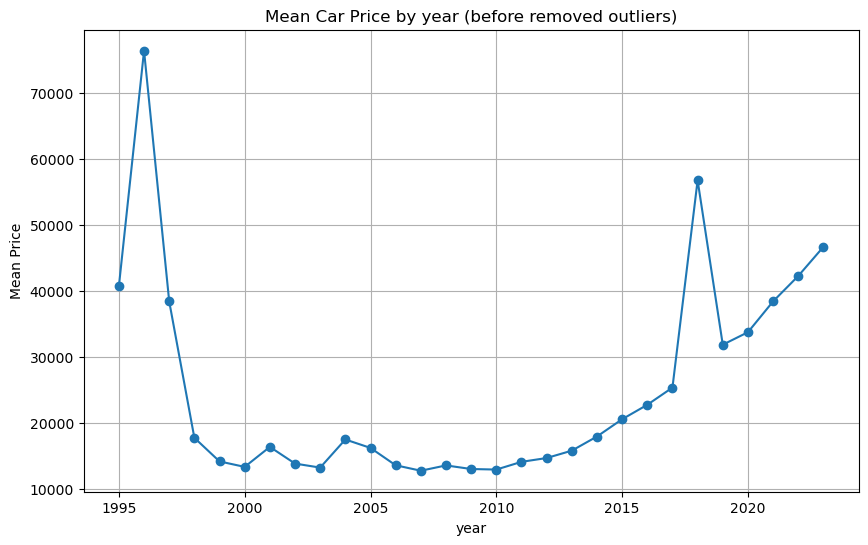

In [13]:

mean_prices_by_year = df.groupby('year')['price'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(mean_prices_by_year['year'], mean_prices_by_year['price'], marker='o', linestyle='-')
plt.title('Mean Car Price by year (before removed outliers)')
plt.xlabel('year')
plt.ylabel('Mean Price')
plt.grid(True)
plt.show()

In [14]:


Q1 = num_columns[numerical_cols].quantile(0.25)
Q3 = num_columns[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers and create a boolean mask
outliers_mask = (num_columns[numerical_cols] < lower_bound) | (num_columns[numerical_cols] > upper_bound)

# Drop the rows containing outliers
num_columns = num_columns[~outliers_mask]

In [15]:
numerical_cols

['year',
 'mileage',
 'accidents_or_damage',
 'one_owner',
 'personal_use_only',
 'seller_rating',
 'driver_rating',
 'driver_reviews_num',
 'price']

This is new numerical columns after removed the outliers

In [16]:
new_num_columns= num_columns.dropna() #drop the rows which are contain NAN 
new_num_columns

,year,mileage,accidents_or_damage,one_owner,personal_use_only,seller_rating,driver_rating,driver_reviews_num,price
0,2023.0,6.0,0.0,0.0,0.0,4.9,4.6,5.0,37434.0
1,2023.0,9705.0,0.0,1.0,1.0,3.6,4.6,5.0,34516.0
2,2023.0,10805.0,0.0,1.0,0.0,4.5,4.6,5.0,37500.0
3,2023.0,6612.0,0.0,1.0,1.0,4.6,4.6,5.0,32995.0
4,2023.0,75.0,0.0,1.0,0.0,3.6,4.6,5.0,34662.0
...,...,...,...,...,...,...,...,...,...
375546,2013.0,97367.0,0.0,0.0,1.0,3.8,4.7,62.0,10490.0
375547,2013.0,117809.0,0.0,0.0,1.0,4.8,4.7,62.0,11995.0
375550,2013.0,106288.0,0.0,0.0,1.0,3.3,4.7,62.0,8995.0
375551,2013.0,83399.0,0.0,0.0,1.0,4.5,4.7,62.0,13947.0


* Plot Average Price vs Years ((after removed outliers))


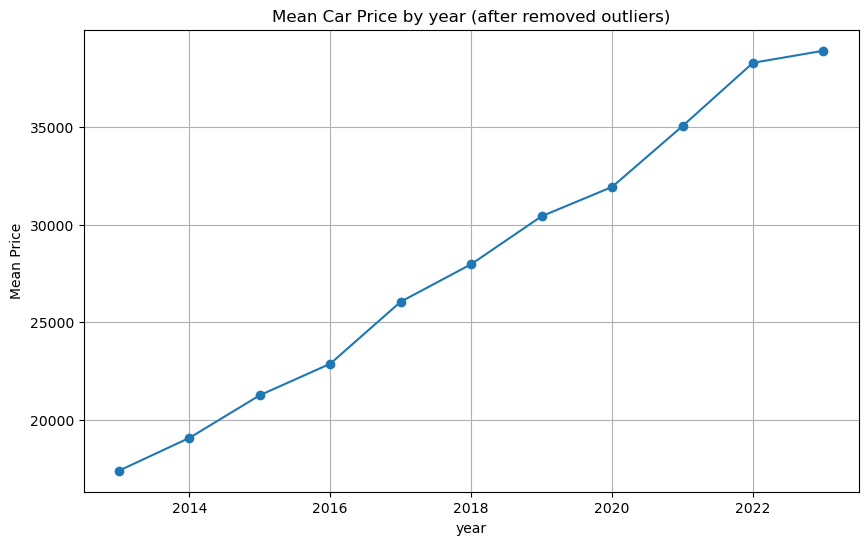

In [17]:

mean_prices_by_year = new_num_columns.groupby('year')['price'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(mean_prices_by_year['year'], mean_prices_by_year['price'], marker='o', linestyle='-')
plt.title('Mean Car Price by year (after removed outliers)')
plt.xlabel('year')
plt.ylabel('Mean Price')
plt.grid(True)
plt.show()

In [18]:
# Define the edges (ranges)
edges = [0, 5000, 10000, 30000, 50000, 70000, 90000, 110000, 130000, 150000, 170000, 190000, 210000,  300000]

# Create labels
labels = ['0-5', '5-10', '10-30', '30-50', '50-70','70-90','90-110','110-130','130-150','150-170','170-190','190-210','210-300']

# Using pd.cut, divide the 'mileage_ranges' column into bins with labels
new_num_columns['mileage_ranges'] = pd.cut(new_num_columns['mileage_in_km'], bins=edges, labels=labels)

# Reorder the categories of the 'mileage_ranges' column
new_num_columns['mileage_ranges'] = pd.Categorical(new_num_columns['mileage_ranges'], categories=labels, ordered=True)

# Group the data by the 'mileage_ranges' column and count the frequency of each range
value_counts = new_num_columns['mileage_ranges'].value_counts()

# Sort the values based on the category order
value_counts = value_counts.sort_index()

# Create the bar plot
fig, ax = plt.subplots()
value_counts.plot(ax=ax, kind='bar', xlabel='Mileage Ranges (in thousands)', ylabel='Frequency')
plt.show()


KeyError: 'mileage_in_km'

In [ ]:
# Convert 'mileage_in_km' column to numeric if it's not already
new_num_columns['mileage_in_km'] = pd.to_numeric(new_num_columns['mileage_in_km'], errors='coerce')

# Define the number of bins and calculate the range based on the data
num_bins = 15
min_range = 0
max_range = new_num_columns['mileage_in_km'].max()

# Create labels with custom ranges
bin_size = (max_range - min_range) / num_bins
labels = [f'{int(min_range + i * bin_size)}-{int(min_range + (i + 1) * bin_size)}' for i in range(num_bins)]

# Using pd.cut, divide the 'mileage_in_km' column into bins with labels
new_num_columns['mileage_ranges'] = pd.cut(new_num_columns['mileage_in_km'], bins=num_bins, labels=labels, include_lowest=True)


# Create the bar plot
fig, ax = plt.subplots()
value_counts = new_num_columns['mileage_ranges'].value_counts()
value_counts[labels].plot(ax=ax, kind='bar', xlabel='Mileage Ranges', ylabel='Frequency')
plt.show()

* ### **For categorical columns:**
We need to plot them vs Price to see the pattern

In [ ]:
cat_columns=['brand','transmission_type','fuel_type', 'color' ] #these are the columns that wee need to plot se dectect the outliers

In [ ]:

# Create a figure with multiple subplots
fig = plt.figure(figsize=(10, 5 * len(cat_columns)))
for i, cat_feature in enumerate(cat_columns):
    ax = fig.add_subplot(len(cat_columns), 1, i + 1)
    df[cat_feature].value_counts().plot(ax=ax, kind='bar', xlabel=cat_feature, ylabel='Frequency')
    ax.set_title(cat_feature)

plt.tight_layout()
plt.show()


<div class="alert alert-block alert-warning">
<b>Discussion:</b>  `Based on these plots for categorical features, we can decide how much data we can remove`
</div>

Let's drop these classes from categorical columns:<br>

* `Unknow`, `Semi-automatic` from `transmission_type` column<br>
* `LPG`, `CNG`, `Diesel Hybrid`, `Hydrogen`, `Electric`, `Ethanol` from `fuel_type` columns

### **!!! We can drop more class if we needed**

In [ ]:
df = df.loc[~df['fuel_type'].isin(['LPG', 'CNG', 'Diesel Hybrid', 'Hydrogen', 'Electric', 'Ethanol'])]
df = df.loc[~df['transmission_type'].isin(['Unknown', 'Semi-automatic'])]
#reset the index
df.reset_index(drop=True)

In [ ]:
'''data= pd.concat([new_num_columns , cat_columns, Y], axis=1)
data = data.dropna().reset_index(drop=True)
data.info()'''